This jupyter notebook process the predicted results, image and ground truth segmentation to provide:
* Superimposed prediction over image
* Superimposed prediction over ground truth
* Superimposed ground truth over image
* Prediction 

for validation and test results in png format


Note:
From [`common_question`](https://github.com/MIC-DKFZ/nnUNet/blob/nnunetv1/documentation/common_questions.md#what-postprocessing-is-selected) in the library. `postprocessing.json` have:

```json
    "for_which_classes": [],
```

Therefore, no postprocessing was applied. That is `validation_raw` and `validation_raw_postprocessed` show the same images

In [1]:
import os
import numpy as np
from nibabel.testing import data_path
import glob
import nibabel as nib
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import pandas as pd
import re
from tqdm import tqdm
import cv2

# CV

## Trying one fold

In [2]:
predicted_dir = "/home/pcallec/nnUNet_blood-vessel/results/nnUNet_trained_models/nnUNet/2d/Task500_BloodVessel/" "nnUNetTrainerV2__nnUNetPlansv2.1/fold_0/validation_raw"

val_predicted_img_paths = glob.glob(predicted_dir + "/*.nii.gz")
val_predicted_img_paths.sort()

In [3]:
# Result for one image
image_temp = nib.load("/home/pcallec/nnUNet_blood-vessel/results/nnUNet_raw_data_base/nnUNet_raw_data/Task500_BloodVessel/imagesTr/0001_0000.nii.gz").get_fdata()
image_temp.shape

(351, 451, 1)

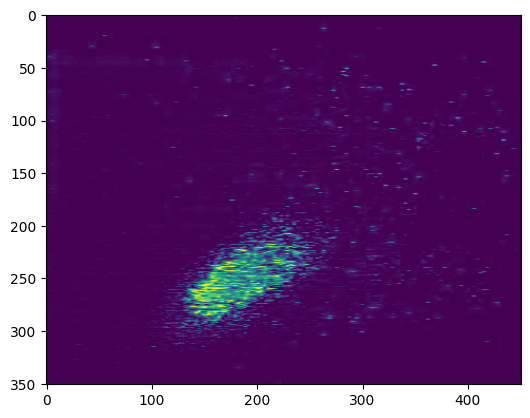

In [4]:
plt.imshow(image_temp)

In [5]:
image_temp2 = nib.load("/home/pcallec/nnUNet_blood-vessel/results/nnUNet_raw_data_base/nnUNet_raw_data/Task500_BloodVessel/imagesTr/0001_0001.nii.gz").get_fdata()
image_temp2.shape

(351, 451, 1)

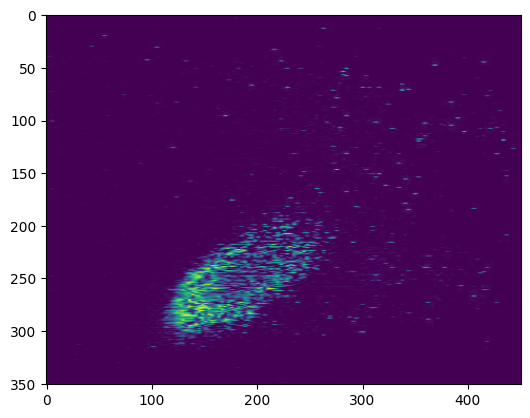

In [6]:
plt.imshow(image_temp2)

In [7]:
image_temp3 = nib.load("/home/pcallec/nnUNet_blood-vessel/results/nnUNet_raw_data_base/nnUNet_raw_data/Task500_BloodVessel/imagesTr/0001_0002.nii.gz").get_fdata()
image_temp3.shape

(351, 451, 1)

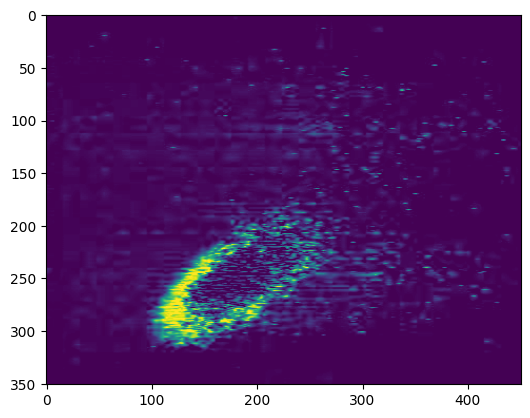

In [8]:
plt.imshow(image_temp3)

In [9]:
image_temp = nib.load("/home/pcallec/nnUNet_blood-vessel/results/nnUNet_raw_data_base/nnUNet_raw_data/Task500_BloodVessel/labelsTr/0001.nii.gz").get_fdata()
image_temp.shape

(351, 451, 1)

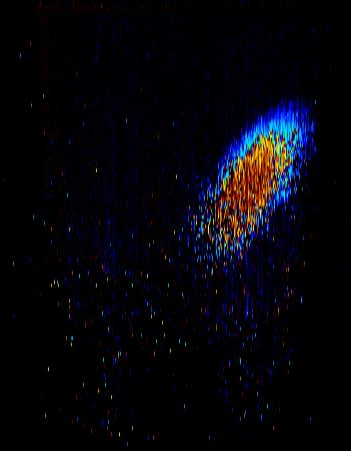

In [10]:
img_pillow = Image.open("/home/pcallec/nnUNet_blood-vessel/data/5000_v3_new_structure/training/input/0001.png")
img_pillow

In [11]:
a_img_pillow = np.array(img_pillow)
a_img_pillow.shape

(451, 351, 3)

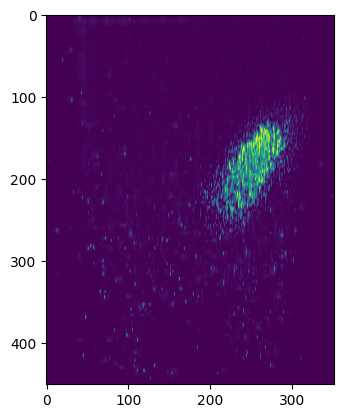

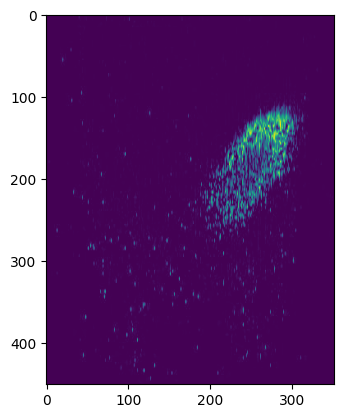

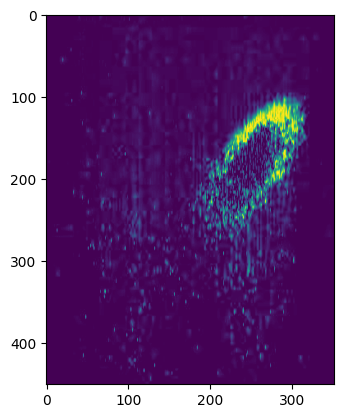

In [12]:
for i in range(3):
    plt.figure()
    plt.imshow(a_img_pillow[:,:,i])

Process images are split in three, one for each Channel (RGB).
* 0001_0000.nii.gz
* 0001_0001.nii.gz
* 0001_0002.nii.gz

In [13]:
len(val_predicted_img_paths)

800

In [14]:
print(val_predicted_img_paths[:5])

['/home/pcallec/nnUNet_blood-vessel/results/nnUNet_trained_models/nnUNet/2d/Task500_BloodVessel/nnUNetTrainerV2__nnUNetPlansv2.1/fold_0/validation_raw/0002.nii.gz', '/home/pcallec/nnUNet_blood-vessel/results/nnUNet_trained_models/nnUNet/2d/Task500_BloodVessel/nnUNetTrainerV2__nnUNetPlansv2.1/fold_0/validation_raw/0003.nii.gz', '/home/pcallec/nnUNet_blood-vessel/results/nnUNet_trained_models/nnUNet/2d/Task500_BloodVessel/nnUNetTrainerV2__nnUNetPlansv2.1/fold_0/validation_raw/0009.nii.gz', '/home/pcallec/nnUNet_blood-vessel/results/nnUNet_trained_models/nnUNet/2d/Task500_BloodVessel/nnUNetTrainerV2__nnUNetPlansv2.1/fold_0/validation_raw/0018.nii.gz', '/home/pcallec/nnUNet_blood-vessel/results/nnUNet_trained_models/nnUNet/2d/Task500_BloodVessel/nnUNetTrainerV2__nnUNetPlansv2.1/fold_0/validation_raw/0019.nii.gz']


0002.nii.gz


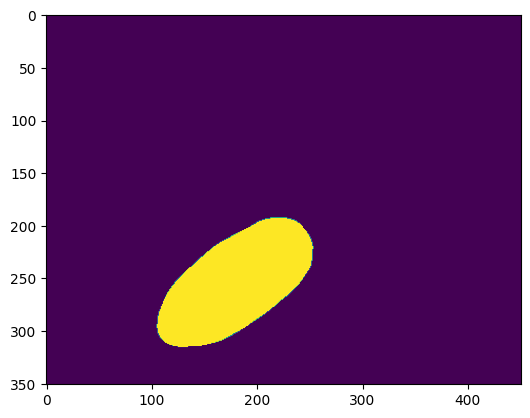

In [15]:
# Plotting predicted segmentation by model

l_truth = []
l_predicted = []

# for i in range(len(testing_predicted_img_paths)):
for i in range(1):
       
    print(os.path.basename(val_predicted_img_paths[i]))
    
    img = nib.load(val_predicted_img_paths[i])
    epi_img_data = img.get_fdata()
    
#     l_truth.append(a_img_pillow[:])
    l_predicted.append(epi_img_data.T[0][:])
    fig = plt.figure()
    plt.imshow(epi_img_data)
#     break

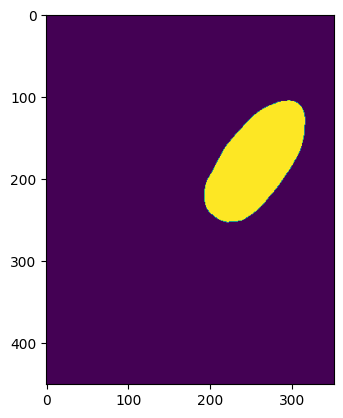

In [16]:
# Image need to be transpose to be match with labeled segmentation


plt.imshow(epi_img_data.T[0][:])

## Overlapped images

In [17]:
dataset_input_dir = "/home/pcallec/nnUNet_blood-vessel/data/5000_All-Doppler-Labeled_Results_v3"

truth_val_input_img_paths = glob.glob(dataset_input_dir + "/*[0-9].png")
# to get image and label?
truth_val_input_img_paths.sort()

In [18]:
print(len(truth_val_input_img_paths))
truth_val_input_img_paths[:5]

5000


['/home/pcallec/nnUNet_blood-vessel/data/5000_All-Doppler-Labeled_Results_v3/0001.png',
 '/home/pcallec/nnUNet_blood-vessel/data/5000_All-Doppler-Labeled_Results_v3/0002.png',
 '/home/pcallec/nnUNet_blood-vessel/data/5000_All-Doppler-Labeled_Results_v3/0003.png',
 '/home/pcallec/nnUNet_blood-vessel/data/5000_All-Doppler-Labeled_Results_v3/0004.png',
 '/home/pcallec/nnUNet_blood-vessel/data/5000_All-Doppler-Labeled_Results_v3/0005.png']

In [19]:
truth_val_label_img_paths = glob.glob(dataset_input_dir + "/*1ch.png")
# to get image and label?
truth_val_label_img_paths.sort()

In [20]:
print(len(truth_val_label_img_paths))
truth_val_label_img_paths[:5]

5000


['/home/pcallec/nnUNet_blood-vessel/data/5000_All-Doppler-Labeled_Results_v3/0001_labeled_1ch.png',
 '/home/pcallec/nnUNet_blood-vessel/data/5000_All-Doppler-Labeled_Results_v3/0002_labeled_1ch.png',
 '/home/pcallec/nnUNet_blood-vessel/data/5000_All-Doppler-Labeled_Results_v3/0003_labeled_1ch.png',
 '/home/pcallec/nnUNet_blood-vessel/data/5000_All-Doppler-Labeled_Results_v3/0004_labeled_1ch.png',
 '/home/pcallec/nnUNet_blood-vessel/data/5000_All-Doppler-Labeled_Results_v3/0005_labeled_1ch.png']

#### Automate

Fold 4 Image: 100%|██████████| 800/800 [01:06<00:00, 12.06it/s]


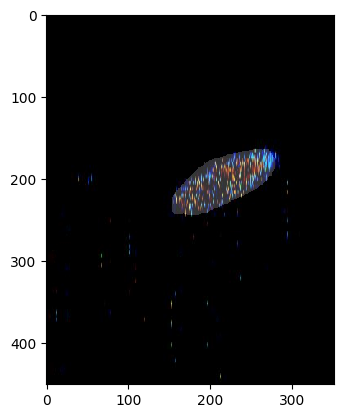

In [24]:
l_truth = []
l_predicted = []

path_dataset = "/home/pcallec/nnUNet_blood-vessel/data/5000_All-Doppler-Labeled_Results_v3"
path_output = "/home/pcallec/nnUNet_blood-vessel/results/processed_results/"

for i in range(5):
    predicted_dir = "/home/pcallec/nnUNet_blood-vessel/results/nnUNet_trained_models/" +\
                    f"nnUNet/2d/Task500_BloodVessel/nnUNetTrainerV2__nnUNetPlansv2.1/fold_{i}/validation_raw"

    val_predicted_img_paths = glob.glob(predicted_dir + "/*.nii.gz")
    val_predicted_img_paths.sort()
    
    for val_predicted_path in tqdm(val_predicted_img_paths, desc=f"Fold {i} Image",
                                   position=0, leave=True,
                                   total=len(val_predicted_img_paths)):
        # TODO
        # Extract number from name to put in name for superimposed image

        re_number = re.compile(r'(?<=/)[0-9]{4}')
        img_number = re_number.search(val_predicted_path).group(0)
        path_label_truth = os.path.join(path_dataset, f"{img_number}_labeled_1ch.png")
        path_image = os.path.join(path_dataset, f"{img_number}.png")

        # print("img_number = ", img_number)
        # print(path_image)
        # print(path_label_truth)


        # Read image
        img_input_pillow = Image.open(path_image)
        a_img_input_pillow = np.array(img_input_pillow)
        # print("a_img_input_pillow.shape = ", a_img_input_pillow.shape)

        # Read label
        img_label_pillow = Image.open(path_label_truth)
        a_img_label_pillow = np.array(img_label_pillow)
        # print("a_img_label_pillow.shape = ", a_img_label_pillow.shape)

        # Changing values of label to 0 and 1
        np.place(a_img_label_pillow, a_img_label_pillow == 53, 0)
        np.place(a_img_label_pillow, a_img_label_pillow == 91, 255)

        # Read prediction
    #     a_img_pillow = np.where(a_img_pillow ==255, 1, a_img_pillow)
        img = nib.load(val_predicted_path)
        epi_img_data = img.get_fdata()
        mask_cv2 = np.uint8(epi_img_data[:,:,0].T)
        mask_cv2_color = cv2.applyColorMap(mask_cv2*255, cv2.COLORMAP_RAINBOW)
    #     plt.imshow(mask_cv2_color, interpolation='nearest')

        # Superimposed prediction over image
        superimposed_img = mask_cv2_color*0.5 + a_img_input_pillow
    #     superimposed_img =  a_img_input_pillow

        # create directory
        path_superimposed = os.path.join(path_output,f"superimposed_pred_over_img/cv")
        os.makedirs(path_superimposed, exist_ok = True)                                 
#         plt.imshow(superimposed_img/np.max(superimposed_img), interpolation='nearest')                                        
        path_superimposed_over_image = os.path.join(path_superimposed,f"superimposed_pred_over_img_{img_number}.png")
        plt.imsave(path_superimposed_over_image,
                   superimposed_img/np.max(superimposed_img))

        # Superimposed prediction over label
        path_superimposed = os.path.join(path_output,f"superimposed_pred_over_label/cv")
        os.makedirs(path_superimposed, exist_ok = True)                                 

        superimposed_img = mask_cv2_color*2.5 + a_img_label_pillow[:,:,None]
#         plt.imshow(superimposed_img/np.max(superimposed_img), interpolation='nearest')
        path_superimposed_over_label = os.path.join(path_superimposed,f"superimposed_over_label_{img_number}.png")

        plt.imsave(path_superimposed_over_label,
                   superimposed_img/np.max(superimposed_img))
    
        # Superimposed label over image
        path_superimposed = os.path.join(path_output,f"superimposed_label_over_img/cv")
        os.makedirs(path_superimposed, exist_ok = True)                                 

        superimposed_img = a_img_label_pillow[:,:,None]*0.25 + a_img_input_pillow
        plt.imshow(superimposed_img/np.max(superimposed_img), interpolation='nearest')
        path_superimposed_over_label = os.path.join(path_superimposed,f"superimposed_label_over_img_{img_number}.png")
    
        plt.imsave(path_superimposed_over_label,
                   superimposed_img/np.max(superimposed_img))
#         break
        # Prediction saved
    #     mask_cv2 has values 0 and 1
        im = Image.fromarray(mask_cv2*255)
        
        # Prediction
        path_prediction = os.path.join(path_output,f"prediction/cv")
        os.makedirs(path_prediction, exist_ok = True)                                 

        path_prediction_image = os.path.join(path_prediction, f"prediction_{img_number}.png")                   
        im.save(path_prediction_image)

#         break

# Test

In [25]:
predicted_dir = "/home/pcallec/nnUNet_blood-vessel/results/test_pred/v3"

test_predicted_img_paths = glob.glob(predicted_dir + "/*.nii.gz")
test_predicted_img_paths.sort()

In [27]:
print("len(test_predicted_img_paths)=", len(test_predicted_img_paths))
test_predicted_img_paths[:5]

len(test_predicted_img_paths)= 1000


['/home/pcallec/nnUNet_blood-vessel/results/test_pred/v3/0013.nii.gz',
 '/home/pcallec/nnUNet_blood-vessel/results/test_pred/v3/0021.nii.gz',
 '/home/pcallec/nnUNet_blood-vessel/results/test_pred/v3/0026.nii.gz',
 '/home/pcallec/nnUNet_blood-vessel/results/test_pred/v3/0028.nii.gz',
 '/home/pcallec/nnUNet_blood-vessel/results/test_pred/v3/0029.nii.gz']

## Overlapped images

### Truth

In [28]:
dataset_input_dir = "/home/pcallec/nnUNet_blood-vessel/data/5000_All-Doppler-Labeled_Results_v3"

truth_val_input_img_paths = glob.glob(dataset_input_dir + "/*[0-9].png")
# to get image and label?
truth_val_input_img_paths.sort()

In [30]:
print(len(truth_val_input_img_paths))
truth_val_input_img_paths[:5]

5000


['/home/pcallec/nnUNet_blood-vessel/data/5000_All-Doppler-Labeled_Results_v3/0001.png',
 '/home/pcallec/nnUNet_blood-vessel/data/5000_All-Doppler-Labeled_Results_v3/0002.png',
 '/home/pcallec/nnUNet_blood-vessel/data/5000_All-Doppler-Labeled_Results_v3/0003.png',
 '/home/pcallec/nnUNet_blood-vessel/data/5000_All-Doppler-Labeled_Results_v3/0004.png',
 '/home/pcallec/nnUNet_blood-vessel/data/5000_All-Doppler-Labeled_Results_v3/0005.png']

In [31]:
truth_val_label_img_paths = glob.glob(dataset_input_dir + "/*1ch.png")
# to get image and label?
truth_val_label_img_paths.sort()

In [32]:
print(len(truth_val_label_img_paths))
truth_val_label_img_paths[:5]

5000


['/home/pcallec/nnUNet_blood-vessel/data/5000_All-Doppler-Labeled_Results_v3/0001_labeled_1ch.png',
 '/home/pcallec/nnUNet_blood-vessel/data/5000_All-Doppler-Labeled_Results_v3/0002_labeled_1ch.png',
 '/home/pcallec/nnUNet_blood-vessel/data/5000_All-Doppler-Labeled_Results_v3/0003_labeled_1ch.png',
 '/home/pcallec/nnUNet_blood-vessel/data/5000_All-Doppler-Labeled_Results_v3/0004_labeled_1ch.png',
 '/home/pcallec/nnUNet_blood-vessel/data/5000_All-Doppler-Labeled_Results_v3/0005_labeled_1ch.png']

### Predicted

#### One fold

In [30]:
predicted_dir = "/home/pcallec/nnUNet_blood-vessel/results/test_pred/v3"

test_predicted_img_paths = glob.glob(predicted_dir + "/*.nii.gz")

In [31]:
test_predicted_img_paths.sort()
test_predicted_img_paths[:5]

['/home/pcallec/nnUNet_blood-vessel/results/test_pred/v3/0013.nii.gz',
 '/home/pcallec/nnUNet_blood-vessel/results/test_pred/v3/0021.nii.gz',
 '/home/pcallec/nnUNet_blood-vessel/results/test_pred/v3/0026.nii.gz',
 '/home/pcallec/nnUNet_blood-vessel/results/test_pred/v3/0028.nii.gz',
 '/home/pcallec/nnUNet_blood-vessel/results/test_pred/v3/0029.nii.gz']

#### Automate

100%|██████████| 1000/1000 [01:18<00:00, 12.80it/s]


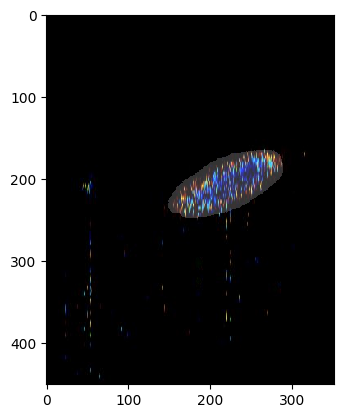

In [34]:
l_truth = []
l_predicted = []

path_dataset = "/home/pcallec/nnUNet_blood-vessel/data/5000_All-Doppler-Labeled_Results_v3"

path_output = "/home/pcallec/nnUNet_blood-vessel/results/processed_results/"

predicted_dir = "/home/pcallec/nnUNet_blood-vessel/results/test_pred/v3"

test_predicted_img_paths = glob.glob(predicted_dir + "/*.nii.gz")
test_predicted_img_paths.sort()

for test_predicted_path in  tqdm(test_predicted_img_paths):
    # TODO
    # Extract number from name to put in name for superimposed image

    re_number = re.compile(r'(?<=/)[0-9]{4}')
    img_number = re_number.search(test_predicted_path).group(0)
    path_label_truth = os.path.join(path_dataset, f"{img_number}_labeled_1ch.png")
    path_image = os.path.join(path_dataset, f"{img_number}.png")

    # print("img_number = ", img_number)
    # print(path_image)
    # print(path_label_truth)


    # Read image
    img_input_pillow = Image.open(path_image)
    a_img_input_pillow = np.array(img_input_pillow)
    # print("a_img_input_pillow.shape = ", a_img_input_pillow.shape)

    # Read label
    img_label_pillow = Image.open(path_label_truth)
    a_img_label_pillow = np.array(img_label_pillow)
    # print("a_img_label_pillow.shape = ", a_img_label_pillow.shape)

    # Changing values of label to 0 and 1
    np.place(a_img_label_pillow, a_img_label_pillow == 53, 0)
    np.place(a_img_label_pillow, a_img_label_pillow == 91, 255)

    # Read prediction
#     a_img_pillow = np.where(a_img_pillow ==255, 1, a_img_pillow)
    img = nib.load(test_predicted_path)
    epi_img_data = img.get_fdata()
    mask_cv2 = np.uint8(epi_img_data[:,:,0].T)
    mask_cv2_color = cv2.applyColorMap(mask_cv2*255, cv2.COLORMAP_RAINBOW)
#     plt.imshow(mask_cv2_color, interpolation='nearest')

    # Superimposed prediction over image
    superimposed_img = mask_cv2_color*0.5 + a_img_input_pillow
#     superimposed_img =  a_img_input_pillow

    # create directory
    path_superimposed = os.path.join(path_output,f"superimposed_pred_over_img/test")
    os.makedirs(path_superimposed, exist_ok = True)                                 
#         plt.imshow(superimposed_img/np.max(superimposed_img), interpolation='nearest')                                        
    path_superimposed_over_image = os.path.join(path_superimposed,f"superimposed_pred_over_img_{img_number}.png")
    plt.imsave(path_superimposed_over_image,
               superimposed_img/np.max(superimposed_img))

    # Superimposed prediction over label
    path_superimposed = os.path.join(path_output,f"superimposed_pred_over_label/test")
    os.makedirs(path_superimposed, exist_ok = True)                                 

    superimposed_img = mask_cv2_color*2.5 + a_img_label_pillow[:,:,None]
#         plt.imshow(superimposed_img/np.max(superimposed_img), interpolation='nearest')
    path_superimposed_over_label = os.path.join(path_superimposed,f"superimposed_pred_over_label_{img_number}.png")

    plt.imsave(path_superimposed_over_label,
               superimposed_img/np.max(superimposed_img))

    # Superimposed label over image
    path_superimposed = os.path.join(path_output,f"superimposed_label_over_img/test")
    os.makedirs(path_superimposed, exist_ok = True)                                 

    superimposed_img = a_img_label_pillow[:,:,None]*0.25 + a_img_input_pillow
    plt.imshow(superimposed_img/np.max(superimposed_img), interpolation='nearest')
    path_superimposed_over_label = os.path.join(path_superimposed,f"superimposed_label_over_img_{img_number}.png")

    plt.imsave(path_superimposed_over_label,
               superimposed_img/np.max(superimposed_img))
#         break
    # Prediction saved
#     mask_cv2 has values 0 and 1
    im = Image.fromarray(mask_cv2*255)

    # Prediction
    path_prediction = os.path.join(path_output,f"prediction/test")
    os.makedirs(path_prediction, exist_ok = True)                                 

    path_prediction_image = os.path.join(path_prediction, f"prediction_{img_number}.png")                   
    im.save(path_prediction_image)

#         break